In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv(Path('..', '..', 'data', 'iris_csv.csv'))

for c in df.columns[0:4]:
    df[c] = (df[c]-df[c].mean())/df[c].std()

df['synth1'] = df['petallength']*df['petalwidth']
df['synth2'] = df['sepallength']*df['petallength']
df['synth3'] = df['sepallength']*df['petalwidth']

for name in df['class'].unique():
    df[f'label-{name}'] = df['class'].map(lambda x: 1 if x == name else 0)

In [3]:
np.random.seed(0)

setosa_idxs = np.arange(0, 50)
versicolor_idxs = np.arange(50, 100)
virginica_idxs = np.arange(100, 150)

p = np.random.permutation(np.arange(50))

setosa_train_idxs = setosa_idxs[p[0:10]]
setosa_test_idxs = setosa_idxs[p[10:]]

versicolor_train_idxs = versicolor_idxs[p[0:10]]
versicolor_test_idxs = versicolor_idxs[p[10:]]

virginica_train_idxs = virginica_idxs[p[0:10]]
virginica_test_idxs = virginica_idxs[p[10:]]

feature_columns = ['sepallength', 'sepalwidth', 'petallength', 'petalwidth']
label_columns = ['label-Iris-setosa', 'label-Iris-versicolor', 'label-Iris-virginica']

xTrain = np.vstack([
    df.iloc[setosa_train_idxs][feature_columns],
    df.iloc[versicolor_train_idxs][feature_columns],
    df.iloc[virginica_train_idxs][feature_columns]
])

yTrain = np.vstack([
    df.iloc[setosa_train_idxs][label_columns],
    df.iloc[versicolor_train_idxs][label_columns],
    df.iloc[virginica_train_idxs][label_columns]
])

xTest = np.vstack([
    df.iloc[setosa_test_idxs][feature_columns],
    df.iloc[versicolor_test_idxs][feature_columns],
    df.iloc[virginica_test_idxs][feature_columns]
])

yTest = np.vstack([
    df.iloc[setosa_test_idxs][label_columns],
    df.iloc[versicolor_test_idxs][label_columns],
    df.iloc[virginica_test_idxs][label_columns]
])

In [4]:
@njit(fastmath=True)
def F(x: np.ndarray) -> np.ndarray:
    return x
    # return np.maximum(np.zeros(x.shape), x)
    # return np.clip(x, -1, 1)
    # return np.tanh(x)


@njit(fastmath=True)
def dF(x: np.ndarray) -> np.ndarray:
    return np.ones(x.shape)
    # return 1 * (x > 0)
    # return np.array([0 if (xi <= -1 or xi >= 1) else 1 for xi in x])
    # return 1-np.square(np.tanh(x))


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) ->np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> float:
    y = np.exp(x)
    return y/np.sum(y)

In [5]:
@njit(fastmath=True)
def grads(xBatch:np.ndarray, w:np.ndarray, Bh:np.ndarray, b:np.ndarray) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    
    dBh = np.zeros(Bh.shape)
    db = np.zeros(b.shape)
    
    u = np.zeros((w.shape[0], w.shape[2]))
    y = np.zeros(w.shape[1])
    
    for i in prange(xBatch.shape[0]):
        u*=0
        y*=0
            
        for j in prange(w.shape[0]):
            u[j] = xBatch[i] @ w[j] + Bh[j]
            y += F(u[j]) @ w[j].T + b[j]
        
        dLdy = 2/(w.shape[0]*w.shape[1]) * (y-xBatch[i])  

        for j in prange(w.shape[0]):            
            dw[j] += np.outer(xBatch[i], dLdy @ w[j] * dF(u[j]))
            
            dBh[j] += dLdy @ w[j] * dF(u[j])
            db[j] += dLdy
            
    return (dw, dBh, db)


class MultiRBM:
    def __init__(self, nIn: int, nH: int, nL:int) -> None:
        self.nIn = nIn
        self.nH = nH
        self.nL = nL
        
        self.w: np.ndarray = np.random.uniform(-1, 1, (nL, nIn, nH))
        
        self.Bh: np.ndarray = np.zeros((nL, nH))
        self.b: np.ndarray = np.zeros((nL, nIn))


    def predict(self, x:np.ndarray) -> np.ndarray:
        y = np.zeros(self.nIn)
        
        for i in range(self.w.shape[0]):
            y += F(x @ self.w[i] + self.Bh[i]) @ self.w[i].T + self.b[i]
            
        return y

    def train(self, xTrain: np.ndarray, lr, batch_size, max_iter) -> None:
        n = xTrain.shape[0]
        
        for k in range(max_iter):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)
            
            dw, dBh, db = grads(xTrain[idxs], self.w, self.Bh, self.b)
            
            self.w -= lr*dw
            
            self.Bh -= lr*dBh
            self.b -= lr*db
        

    def loss(self, x: np.ndarray) -> float:
        Xpred = np.array([self.predict(xi) for xi in x])
        d = 1/(self.nL*self.nIn) * np.linalg.norm(x-Xpred, axis=1)        
        return 1/x.shape[0] * np.sum(d)


In [6]:
nIn = 4
nH = 2
nL = 2

lr = 1e-2
batch_size = 30
max_iter = 10000

model = MultiRBM(nIn, nH, nL)

print('untrained loss: {0:.6f}'.format(model.loss(xTest)))

model.train(xTrain, lr, batch_size, max_iter)

print('trained loss: {0:.6f}'.format(model.loss(xTest)))

untrained loss: 0.255520
trained loss: 0.000000


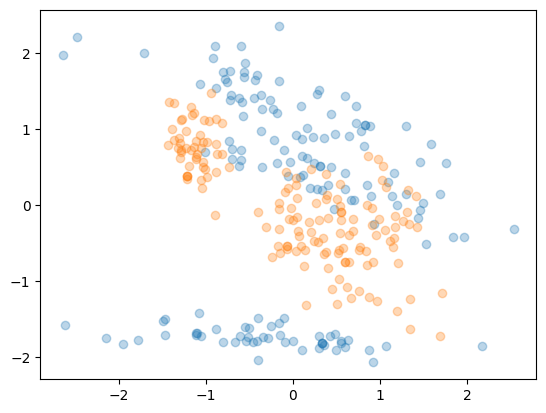

In [7]:
h_proj = []

for i in range(model.nL):
    h = []
    for x in df[feature_columns].to_numpy():
        h.append(F(x @ model.w[i] + model.Bh[i]))
    h_proj.append(np.array(h))

for h in h_proj:
    plt.scatter(h[:,0], h[:,1], alpha=0.3)
    
plt.show()

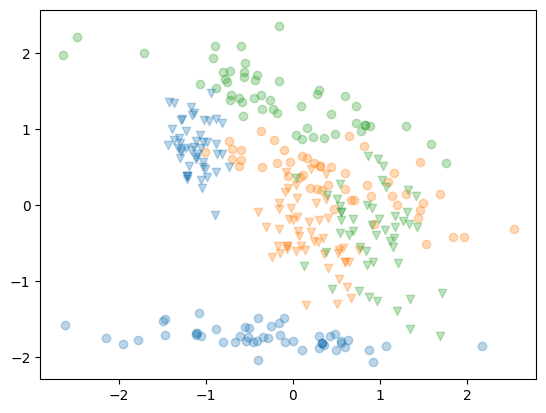

In [8]:
h_proj = []

for i in range(model.nL):
    h = []
    for x in df[feature_columns].to_numpy():
        h.append(F(x @ model.w[i] + model.Bh[i]))
    h_proj.append(np.array(h))

markers = ['o', 'v', 's']

for i, h in enumerate(h_proj):
    plt.scatter(h[0:50,0], h[0:50,1], marker=markers[i], alpha=0.3)
    plt.scatter(h[50:100,0], h[50:100,1], marker=markers[i], alpha=0.3)
    plt.scatter(h[100:150,0], h[100:150,1], marker=markers[i], alpha=0.3)
    plt.gca().set_prop_cycle(None)
    
plt.show()

In [9]:
for x in xTest:
    xPred = model.predict(x)
    print(x.round(2), xPred.round(2), np.linalg.norm(x-xPred).round(3))

[-0.41  2.64 -1.34 -1.31] [-0.41  2.64 -1.34 -1.31] 0.0
[-1.02  0.34 -1.45 -1.31] [-1.02  0.34 -1.45 -1.31] 0.0
[-1.02  0.8  -1.22 -1.05] [-1.02  0.8  -1.22 -1.05] 0.0
[-1.14  0.11 -1.28 -1.44] [-1.14  0.11 -1.28 -1.44] 0.0
[-0.17  1.72 -1.17 -1.18] [-0.17  1.72 -1.17 -1.18] 0.0
[-1.02  0.8  -1.28 -1.31] [-1.02  0.8  -1.28 -1.31] 0.0
[-0.05  2.18 -1.45 -1.31] [-0.05  2.18 -1.45 -1.31] 0.0
[-1.26 -0.12 -1.34 -1.18] [-1.26 -0.12 -1.34 -1.18] 0.0
[-0.66  1.49 -1.28 -1.31] [-0.66  1.49 -1.28 -1.31] 0.0
[-1.38  0.34 -1.22 -1.31] [-1.38  0.34 -1.22 -1.31] 0.0
[-0.17  3.1  -1.28 -1.05] [-0.17  3.1  -1.28 -1.05] 0.0
[-1.26  0.11 -1.22 -1.31] [-1.26  0.11 -1.22 -1.31] 0.0
[-0.78  2.41 -1.28 -1.44] [-0.78  2.41 -1.28 -1.44] 0.0
[-0.54  1.95 -1.39 -1.05] [-0.54  1.95 -1.39 -1.05] 0.0
[-1.74  0.34 -1.39 -1.31] [-1.74  0.34 -1.39 -1.31] 0.0
[-0.54  0.8  -1.17 -1.31] [-0.54  0.8  -1.17 -1.31] 0.0
[-1.02  1.03 -1.22 -0.78] [-1.02  1.03 -1.22 -0.78] 0.0
[-1.74 -0.36 -1.34 -1.31] [-1.74 -0.36 -1.34 -1.